# Install dependencies

In [ ]:
!pip install matplotlib seaborn scikit-learn

In [ ]:
import os
import re
import requests
import torch
import json
from transformers import AutoProcessor, AutoModelForCausalLM
import time
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df = pd.read_csv('/content/memes_thoughts.csv')

# For each Thought, compute embeddings with sBERT

In [ ]:
sentence_embedder = SentenceTransformer('all-mpnet-base-v2')

# Group data by "Meme name"
grouped = df.groupby("Meme name")

# Store results
embeddings_dataset = []

for meme_name, group in grouped:
    # Generate embeddings for the "Meme" texts
    embeddings = sentence_embedder.encode(group["Thought"].tolist())
    languages = group['Language'].tolist()

    for language, embedding in zip(languages, embeddings):
        embeddings_dataset.append({
            "Meme name": meme_name,
            "Language": language,
            "Embedding": embedding
        })

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Embeddings projection (2D)



In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
import umap.umap_ as umap
#from umap import UMAP

def project_embeddings_2d(embeddings, labels, languages, method="tsne", perplexity=30, n_neighbors=15, min_dist=0.1):
    """
    Project high-dimensional embeddings into a 2D space using t-SNE or UMAP.

    Args:
        embeddings (np.ndarray): Array of shape (num_samples, embedding_dim).
        labels (list): List of labels corresponding to each embedding.
        languages (list): List of languages corresponding to each embedding.
        method (str): Dimensionality reduction method ('tsne' or 'umap').
        perplexity (int): Perplexity parameter for t-SNE (default: 30).
        n_neighbors (int): Number of neighbors for UMAP (default: 15).
        min_dist (float): Minimum distance between points for UMAP (default: 0.1).

    Returns:
        None: Displays an interactive 2D plot of the embeddings.
    """
    # Reduce embeddings to 2D
    if method == "tsne":
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'umap'.")

    reduced_embeddings = reducer.fit_transform(embeddings)

    # Define a mapping for shapes based on languages
    language_shapes = {
        "English": "circle",
        "Chinese": "triangle-up",
        "French": "square"
    }
    # Ensure each language has a default shape if not predefined
    unique_languages = list(set(languages))
    for i, lang in enumerate(unique_languages):
        if lang not in language_shapes:
            language_shapes[lang] = ["circle", "triangle-up", "square"][i % 3]  # Cycle through available shapes

    # Prepare data for visualization
    data = {
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "Label": labels,
        "Language": languages,
        "Shape": "circle"
    }

    # Create an interactive scatter plot
    fig = px.scatter(
        data,
        x="x",
        y="y",
        color="Label",  # Use the label for coloring
        symbol="Shape",  # Use the shape for language differentiation
        hover_data=["Label", "Language"],
        title=f"2D Projection of Embeddings using {method.upper()}"
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(title_font_size=20, legend_title_font_size=14)
    fig.show()


embeddings = np.array([emb['Embedding'] for emb in embeddings_dataset])
labels = [emb['Meme name'] for emb in embeddings_dataset]
languages = [emb['Language'] for emb in embeddings_dataset]

# Visualize with t-SNE
project_embeddings_2d(embeddings, labels, languages, method="tsne", perplexity=30)

# Visualize with UMAP
project_embeddings_2d(embeddings, labels, languages, method="umap", n_neighbors=15, min_dist=0.1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
import umap.umap_ as umap
#from umap import UMAP

def project_embeddings_2d(embeddings, labels, languages, method="tsne", perplexity=30, n_neighbors=15, min_dist=0.1):
    """
    Project high-dimensional embeddings into a 2D space using t-SNE or UMAP.

    Args:
        embeddings (np.ndarray): Array of shape (num_samples, embedding_dim).
        labels (list): List of labels corresponding to each embedding.
        languages (list): List of languages corresponding to each embedding.
        method (str): Dimensionality reduction method ('tsne' or 'umap').
        perplexity (int): Perplexity parameter for t-SNE (default: 30).
        n_neighbors (int): Number of neighbors for UMAP (default: 15).
        min_dist (float): Minimum distance between points for UMAP (default: 0.1).

    Returns:
        None: Displays an interactive 2D plot of the embeddings.
    """
    # Reduce embeddings to 2D
    if method == "tsne":
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'umap'.")

    reduced_embeddings = reducer.fit_transform(embeddings)

    # Define a mapping for shapes based on languages
    language_shapes = {
        "English": "circle",
        "Chinese": "triangle-up",
        "French": "square"
    }
    # Ensure each language has a default shape if not predefined
    unique_languages = list(set(languages))
    for i, lang in enumerate(unique_languages):
        if lang not in language_shapes:
            language_shapes[lang] = ["circle", "triangle-up", "square"][i % 3]  # Cycle through available shapes

    # Prepare data for visualization
    data = {
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "Label": labels,
        "Language": languages,
        "Shape": [language_shapes[lang] for lang in languages]
    }

    # Create an interactive scatter plot
    fig = px.scatter(
        data,
        x="x",
        y="y",
        color="Label",  # Use the label for coloring
        symbol="Shape",  # Use the shape for language differentiation
        hover_data=["Label", "Language"],
        title=f"2D Projection of Embeddings using {method.upper()}"
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(title_font_size=20, legend_title_font_size=14)
    fig.show()


embeddings = np.array([emb['Embedding'] for emb in embeddings_dataset])
labels = [emb['Meme name'] for emb in embeddings_dataset]
languages = [emb['Language'] for emb in embeddings_dataset]

# Visualize with t-SNE
project_embeddings_2d(embeddings, labels, languages, method="tsne", perplexity=30)

# Visualize with UMAP
project_embeddings_2d(embeddings, labels, languages, method="umap", n_neighbors=15, min_dist=0.1)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
import umap.umap_ as umap
#from umap import UMAP

def project_embeddings_2d(embeddings, labels, languages, method="tsne", perplexity=30, n_neighbors=15, min_dist=0.1):
    """
    Project high-dimensional embeddings into a 2D space using t-SNE or UMAP.

    Args:
        embeddings (np.ndarray): Array of shape (num_samples, embedding_dim).
        labels (list): List of labels corresponding to each embedding.
        languages (list): List of languages corresponding to each embedding.
        method (str): Dimensionality reduction method ('tsne' or 'umap').
        perplexity (int): Perplexity parameter for t-SNE (default: 30).
        n_neighbors (int): Number of neighbors for UMAP (default: 15).
        min_dist (float): Minimum distance between points for UMAP (default: 0.1).

    Returns:
        None: Displays an interactive 2D plot of the embeddings.
    """
    # Reduce embeddings to 2D
    if method == "tsne":
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'umap'.")


    reduced_embeddings = reducer.fit_transform(embeddings)

    # Prepare data for visualization
    data = {
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "Label": labels,
        "Language": languages
    }

    # Create an interactive scatter plot
    fig = px.scatter(
        data,
        x="x",
        y="y",
        color="Language",
        hover_data=["Label"],
        title=f"2D Projection of Embeddings using {method.upper()}"
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(title_font_size=20, legend_title_font_size=14)
    fig.show()


embeddings = np.array([emb['Embedding'] for emb in embeddings_dataset])
labels = [emb['Meme name'] for emb in embeddings_dataset]
languages = [emb['Language'] for emb in embeddings_dataset]

# Visualize with t-SNE
project_embeddings_2d(embeddings, labels, languages, method="tsne", perplexity=30)

# Visualize with UMAP
project_embeddings_2d(embeddings, labels, languages, method="umap", n_neighbors=15, min_dist=0.1)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Embeddings projection (3D)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
import umap.umap_ as umap

def project_embeddings_3d(embeddings, labels, languages, method="tsne", perplexity=30, n_neighbors=15, min_dist=0.1):
    """
    Project high-dimensional embeddings into a 3D space using t-SNE or UMAP.

    Args:
        embeddings (np.ndarray): Array of shape (num_samples, embedding_dim).
        labels (list): List of labels corresponding to each embedding.
        languages (list): List of languages corresponding to each embedding.
        method (str): Dimensionality reduction method ('tsne' or 'umap').
        perplexity (int): Perplexity parameter for t-SNE (default: 30).
        n_neighbors (int): Number of neighbors for UMAP (default: 15).
        min_dist (float): Minimum distance between points for UMAP (default: 0.1).

    Returns:
        None: Displays an interactive 3D plot of the embeddings.
    """
    # Reduce embeddings to 3D
    if method == "tsne":
        reducer = TSNE(n_components=3, perplexity=perplexity, random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=3, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'umap'.")

    reduced_embeddings = reducer.fit_transform(embeddings)

    # Prepare data for visualization
    data = {
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "z": reduced_embeddings[:, 2],
        "Label": labels,
        "Language": languages
    }

    # Create an interactive 3D scatter plot
    fig = px.scatter_3d(
        data,
        x="x",
        y="y",
        z="z",
        color="Language",
        hover_data=["Label"],
        title=f"3D Projection of Embeddings using {method.upper()}"
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(title_font_size=20, legend_title_font_size=14)
    fig.show()


# Example data
embeddings = np.array([emb['Embedding'] for emb in embeddings_dataset])
labels = [emb['Meme name'] for emb in embeddings_dataset]
languages = [emb['Language'] for emb in embeddings_dataset]

# Visualize with t-SNE in 3D
project_embeddings_3d(embeddings, labels, languages, method="tsne", perplexity=30)

# Visualize with UMAP in 3D
project_embeddings_3d(embeddings, labels, languages, method="umap", n_neighbors=15, min_dist=0.1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA  # Import PCA

def project_embeddings_3d_pca(embeddings, labels, languages, n_components=30):
    """
    Project high-dimensional embeddings into a 3D space using PCA.

    Args:
        embeddings (np.ndarray): Array of shape (num_samples, embedding_dim).
        labels (list): List of labels corresponding to each embedding.
        languages (list): List of languages corresponding to each embedding.
        n_components (int): Number of principal components for PCA (default: 3).

    Returns:
        None: Displays an interactive 3D plot of the embeddings.
    """
    # Reduce embeddings to 3D using PCA
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Prepare data for visualization
    data = {
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "z": reduced_embeddings[:, 2],
        "Label": labels,
        "Language": languages
    }

    # Create an interactive 3D scatter plot
    fig = px.scatter_3d(
        data,
        x="x",
        y="y",
        z="z",
        color="Language",
        hover_data=["Label"],
        title="3D Projection of Embeddings using PCA"
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(title_font_size=20, legend_title_font_size=14)
    fig.show()


# Example data
embeddings = np.array([emb['Embedding'] for emb in embeddings_dataset])
labels = [emb['Meme name'] for emb in embeddings_dataset]
languages = [emb['Language'] for emb in embeddings_dataset]

# Visualize with PCA in 3D
project_embeddings_3d_pca(embeddings, labels, languages, n_components=3)


# Conceptual network

In [ ]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity

def create_conceptual_network_3d(embeddings, labels, languages, threshold=0.8):
    """
    Creates and displays a 3D interactive network based on meme embeddings.

    Args:
        embeddings (np.ndarray): Array with meme embeddings (num_meme x embedding_dim).
        labels (list): List of labels for each meme.
        languages (list): List of languages for each meme.
        threshold (float): Similarity threshold to create edges (default: 0.8).

    Returns:
        None: Displays an interactive 3D visualization.
    """
    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)

    # Create the graph
    graph = nx.Graph()

    # Add nodes to the graph
    for i, label in enumerate(labels):
        graph.add_node(i, label=label, language=languages[i])

    # Add edges based on cosine similarity threshold
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] > threshold:
                graph.add_edge(i, j, weight=similarity_matrix[i, j])

    # Create 3D layout positions using spring layout
    pos = nx.spring_layout(graph, dim=3, seed=42)  # 3D layout

    # Create Plotly traces for nodes and edges
    edge_x = []
    edge_y = []
    edge_z = []
    edge_weights = []

    for edge in graph.edges(data=True):
        node1, node2, weight = edge
        x1, y1, z1 = pos[node1]
        x2, y2, z2 = pos[node2]

        edge_x += [x1, x2, None]
        edge_y += [y1, y2, None]
        edge_z += [z1, z2, None]
        edge_weights.append(weight['weight'])

    # Create node positions for 3D plot
    node_x = []
    node_y = []
    node_z = []
    node_colors = []

    for i in graph.nodes():
        x, y, z = pos[i]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)
        node_colors.append(languages[i])  # Color by language

    # Define color mapping for languages
    color_map = {"English": "blue", "French": "green", "Chinese": "red"}
    node_colors = [color_map[lang] for lang in node_colors]

    # Create edge trace
    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        line=dict(width=0.5, color='gray'),
        hoverinfo='none',
        mode='lines'
    )

    # Create node trace
    node_trace = go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Viridis',
            size=3,
            color=node_colors,
            opacity=0.8
        )
    )

    # Add node labels (optional)
    node_labels = [f"{labels[i]} ({languages[i]})" for i in range(len(labels))]
    node_trace.text = node_labels

    # Create the figure and add traces
    fig = go.Figure(data=[edge_trace, node_trace])

    # Update layout for better visualization
    fig.update_layout(
        title="3D Conceptual Network of Memes",
        title_x=0.5,
        showlegend=False,
        scene=dict(
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False),
            zaxis=dict(showgrid=False, zeroline=False)
        ),
        margin=dict(t=0, b=0, l=0, r=0)
    )

    # Show the plot
    fig.show()

embeddings = [emb['Embedding'] for emb in embeddings_dataset]
labels = [emb['Meme name'] for emb in embeddings_dataset]
languages = [emb['Language'] for emb in embeddings_dataset]

# Create and display the 3D conceptual network
create_conceptual_network_3d(embeddings, labels, languages, threshold=0.8)


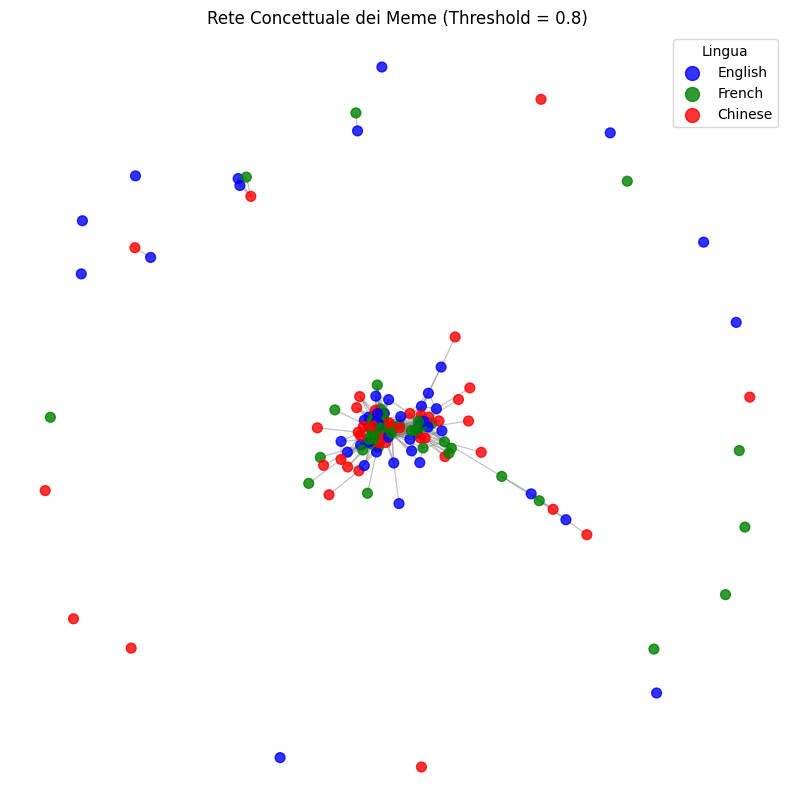

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def create_conceptual_network(embeddings, labels, languages, threshold):
    """
    Crea e visualizza una rete concettuale basata sugli embeddings dei meme.

    Args:
        embeddings (np.ndarray): Array numpy con gli embeddings (dimensione: num_meme x embedding_dim).
        labels (list): Lista di etichette per ogni meme.
        languages (list): Lista di lingue associate a ogni meme.
        threshold (float): Soglia di similarità per creare spigoli nella rete (default: 0.8).

    Returns:
        None: Mostra una visualizzazione del grafo.
    """
    # Calcolo della similarità coseno
    similarity_matrix = cosine_similarity(embeddings)

    # Creazione del grafo
    graph = nx.Graph()

    # Aggiunta dei nodi
    for i, label in enumerate(labels):
        graph.add_node(i, label=label, language=languages[i])

    # Aggiunta degli spigoli (connessioni con similarità > soglia)
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] > threshold:
                graph.add_edge(i, j, weight=similarity_matrix[i, j])

    # Visualizzazione della rete
    plt.figure(figsize=(10, 10))

    # Layout per il grafo
    pos = nx.spring_layout(graph, seed=42)  # Layout a molla

    # Disegna i nodi, colorati per lingua
    node_colors = [languages[node] for node in graph.nodes]
    color_map = {"English": "blue", "French": "green", "Chinese": "red"}
    node_colors = [color_map[lang] for lang in node_colors]
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=50, alpha=0.8)

    # Disegna gli spigoli
    weights = nx.get_edge_attributes(graph, "weight").values()
    nx.draw_networkx_edges(graph, pos, alpha=0.5, edge_color="gray", width=list(weights))

    # Disegna le etichette
    #node_labels = nx.get_node_attributes(graph, "label")
    #nx.draw_networkx_labels(graph, pos, node_labels, font_size=10, font_color="black")

    # Aggiungi legenda
    for lang, color in color_map.items():
        plt.scatter([], [], c=color, label=lang, s=100, alpha=0.8)
    plt.legend(title="Lingua")

    plt.title(f"Rete Concettuale dei Meme (Threshold = {threshold})")
    plt.axis("off")
    plt.show()



embeddings = [emb['Embedding'] for emb in embeddings_dataset]
labels = [emb['Meme name'] for emb in embeddings_dataset]
languages = [emb['Language'] for emb in embeddings_dataset]

# Creazione e visualizzazione della rete
create_conceptual_network(embeddings, labels, languages, threshold=0.8)


# Cluster embeddings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
import umap.umap_ as umap

def cluster_embeddings(embeddings, labels, languages, method="kmeans", n_clusters=5, eps=0.5, min_samples=5, visualize=True):
    """
    Cluster high-dimensional embeddings using K-Means or DBSCAN and optionally visualize results.

    Args:
        embeddings (np.ndarray): Array of shape (num_samples, embedding_dim).
        labels (list): List of labels corresponding to each embedding.
        languages (list): List of languages corresponding to each embedding.
        method (str): Clustering method ('kmeans' or 'dbscan').
        n_clusters (int): Number of clusters for K-Means (default: 5).
        eps (float): Maximum distance between points for DBSCAN (default: 0.5).
        min_samples (int): Minimum samples for a cluster in DBSCAN (default: 5).
        visualize (bool): Whether to visualize the clusters in 2D (default: True).

    Returns:
        np.ndarray: Cluster labels for each point.
    """
    # Perform clustering
    if method == "kmeans":
        model = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = model.fit_predict(embeddings)
    elif method == "dbscan":
        model = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = model.fit_predict(embeddings)
    else:
        raise ValueError("Invalid method. Choose 'kmeans' or 'dbscan'.")

    # Visualize clusters in 2D if requested
    if visualize:
        # Reduce dimensionality for visualization (using t-SNE)
        reducer = TSNE(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)

        # Prepare data for visualization
        data = {
            "x": reduced_embeddings[:, 0],
            "y": reduced_embeddings[:, 1],
            "Label": labels,
            "Language": languages,
            "Cluster": cluster_labels.astype(str)  # Convert to string for color mapping
        }

        # Create an interactive scatter plot
        fig = px.scatter(
            data,
            x="x",
            y="y",
            color="Cluster",
            hover_data=["Label", "Language"],
            title=f"Clustering of Embeddings using {method.upper()}"
        )
        fig.update_traces(marker=dict(size=8, opacity=0.7))
        fig.update_layout(title_font_size=20, legend_title_font_size=14)
        fig.show()

    return cluster_labels



embeddings = np.array([emb['Embedding'] for emb in embeddings_dataset])
labels = [emb['Meme name'] for emb in embeddings_dataset]
languages = [emb['Language'] for emb in embeddings_dataset]

# Perform K-Means clustering
print("K-Means Clustering:")
cluster_labels_kmeans = cluster_embeddings(embeddings, labels, languages, method="kmeans", n_clusters=5)

# Perform DBSCAN clustering
print("DBSCAN Clustering:")
cluster_labels_dbscan = cluster_embeddings(embeddings, labels, languages, method="dbscan", eps=0.5, min_samples=3)



K-Means Clustering:


DBSCAN Clustering:


# Fix an emotion, find the best meme representing it (any language)

In [ ]:
USER_INPUT = "conflict"

input_embedding = sentence_embedder.encode(USER_INPUT)

best_match = {}
best_score = 0

for record in embeddings_dataset:
    cos_sim = cosine_similarity([input_embedding], [record["Embedding"]])[0][0]
    if cos_sim > best_score:
        best_score = cos_sim
        best_match = {
            "Meme name": record["Meme name"],
            "Language": record["Language"],
            "Cosine Similarity": cos_sim
        }

best_match_meme = best_match["Meme name"]
best_match_language = best_match["Language"]

print(f"The closest meme associated with '{USER_INPUT}' is the '{best_match_meme}' meme in {best_match_language}.")

The closest meme associated with 'conflict' is the 'Spiderman pointing at spiderman' meme in Chinese.


# Fix an emotion, find the best meme representing it (distinct languages)

In [ ]:
USER_INPUT = "Anxiety, Paralysis, Exaggeration"

input_embedding = sentence_embedder.encode(USER_INPUT)

for lang in df['Language'].unique():
  best_match = {}
  best_score = 0
  for record in embeddings_dataset:
    if record["Language"] == lang:
      cos_sim = cosine_similarity([input_embedding], [record["Embedding"]])[0][0]
      if cos_sim > best_score:
        best_score = cos_sim
        best_match = {
            "Meme name": record["Meme name"],
            "Language": record["Language"],
            "Cosine Similarity": cos_sim
        }

  best_match_meme = best_match["Meme name"]

  print(f"The closest meme associated with '{USER_INPUT}' in {lang} is the '{best_match_meme}' meme.")

The closest meme associated with 'Anxiety, Paralysis, Exaggeration' in English is the 'Two Buttons' meme.
The closest meme associated with 'Anxiety, Paralysis, Exaggeration' in French is the 'Distracted boyfriend' meme.
The closest meme associated with 'Anxiety, Paralysis, Exaggeration' in Chinese is the 'Surprised Joey' meme.


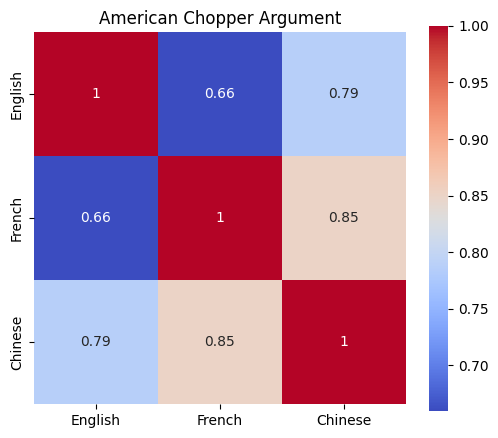

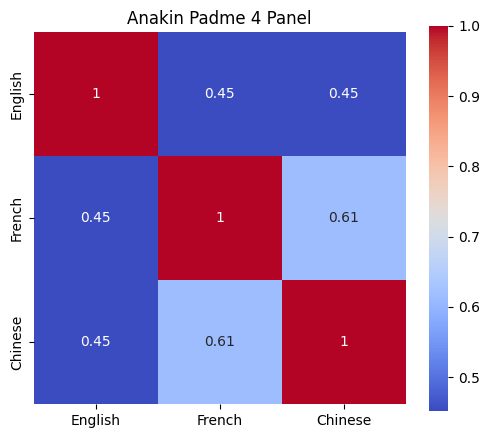

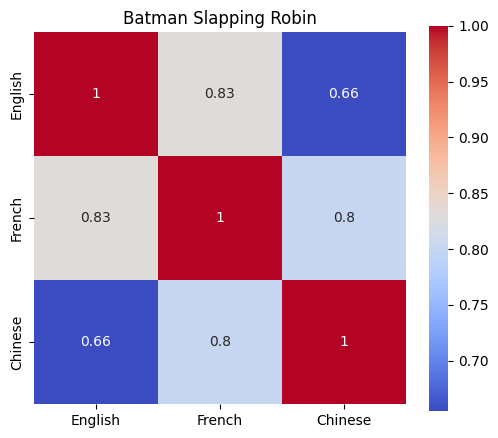

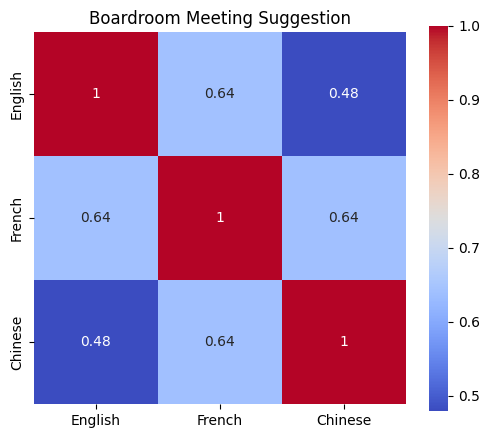

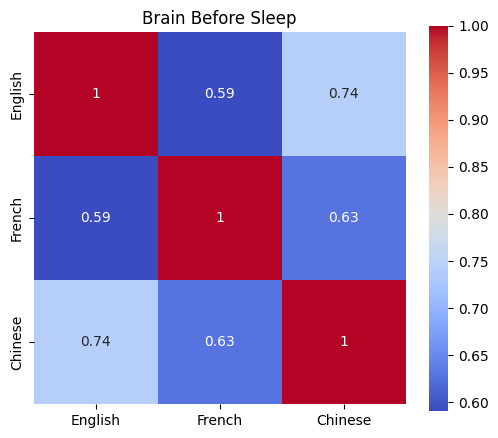

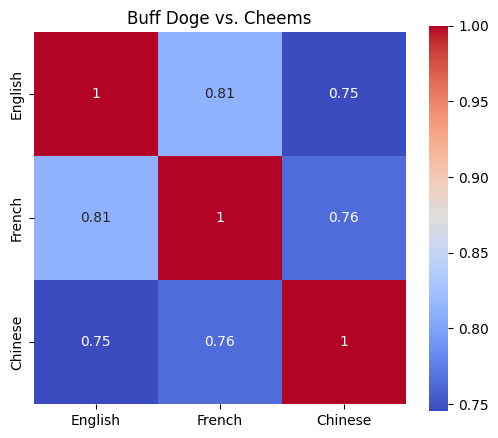

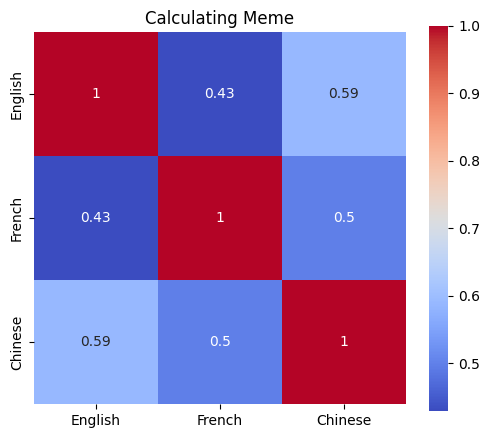

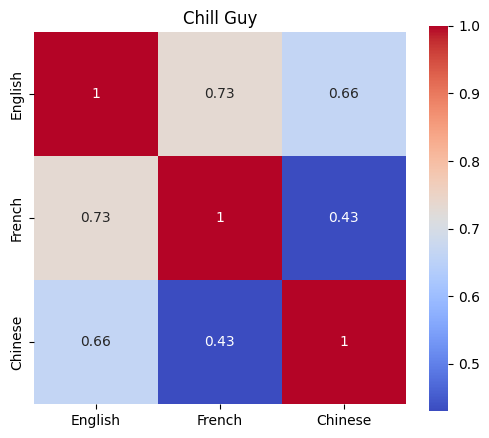

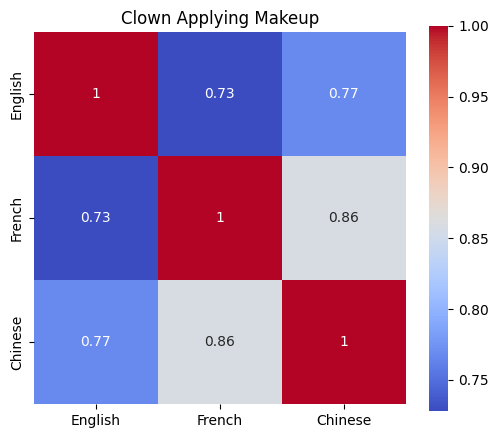

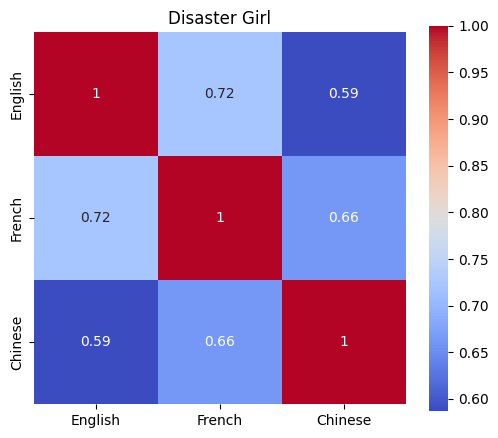

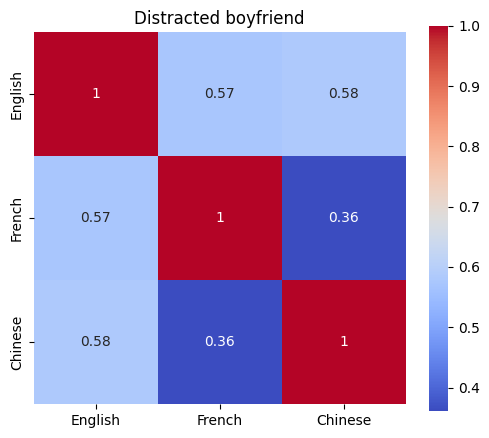

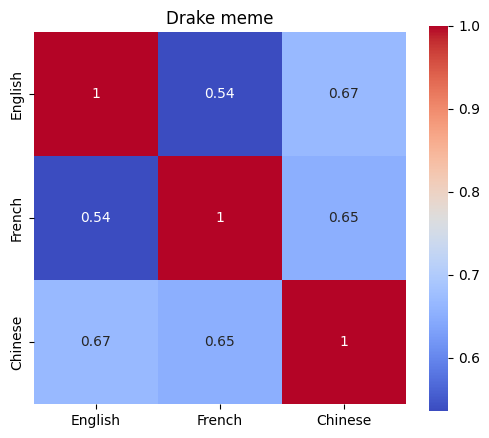

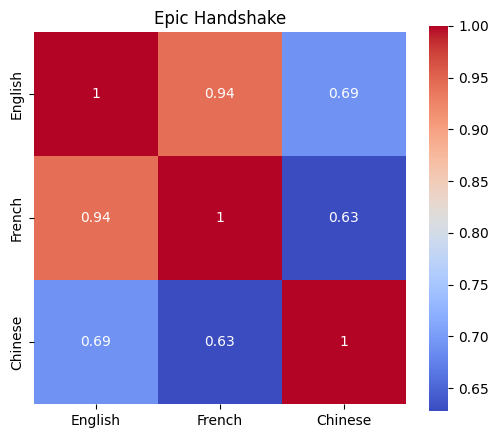

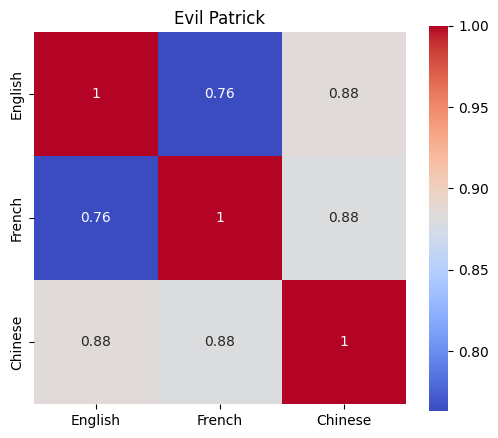

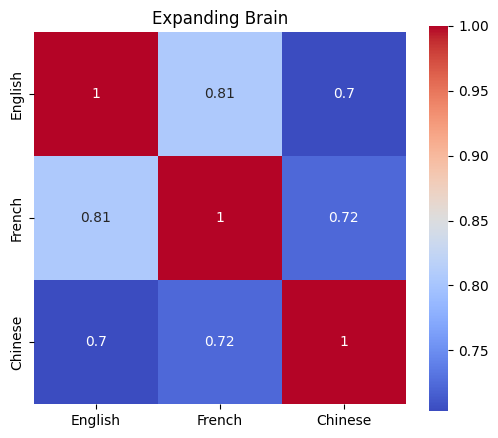

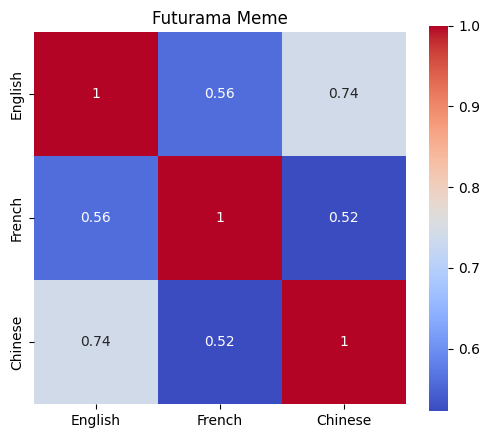

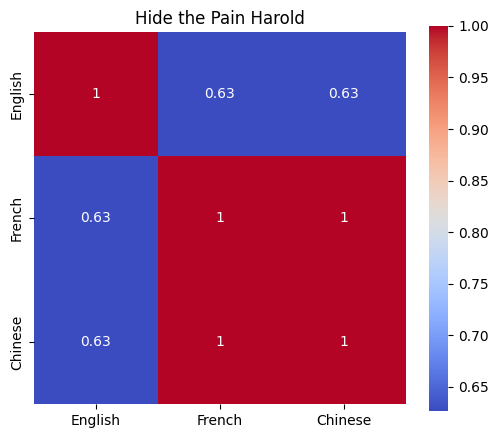

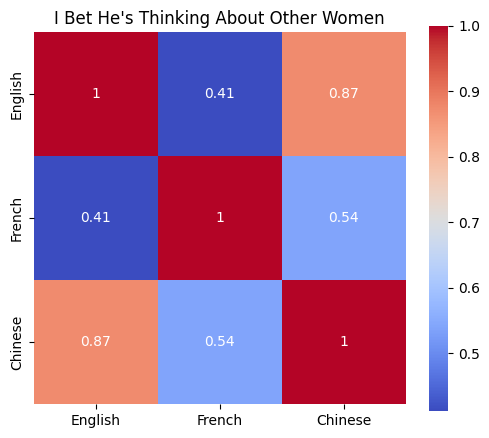

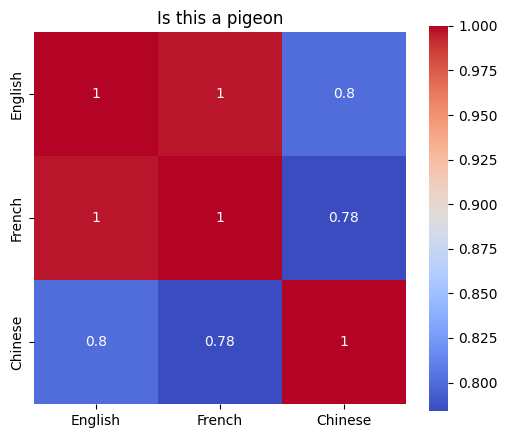

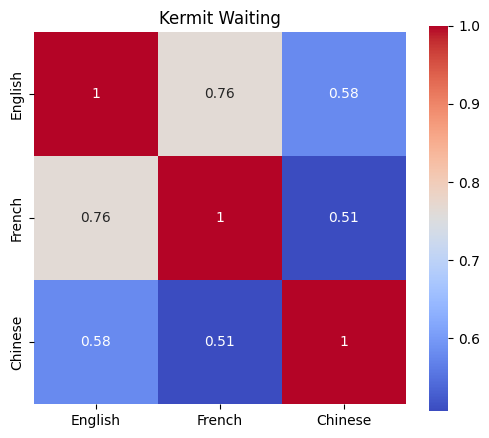

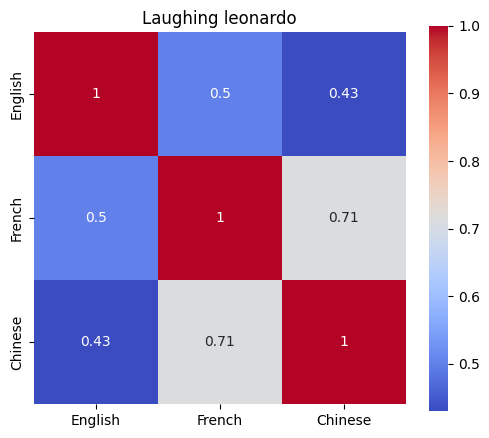

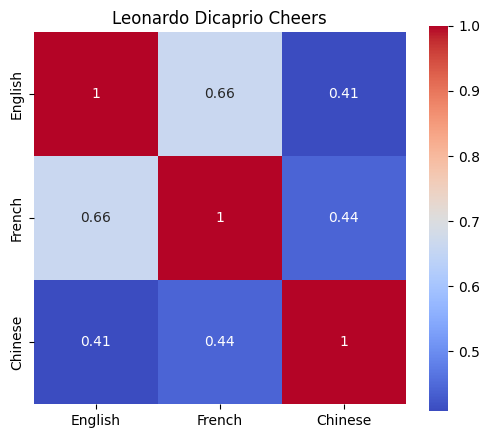

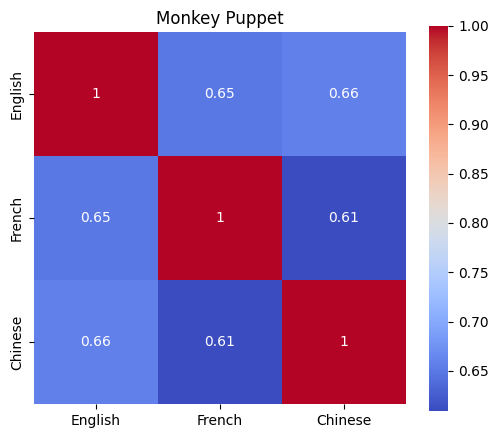

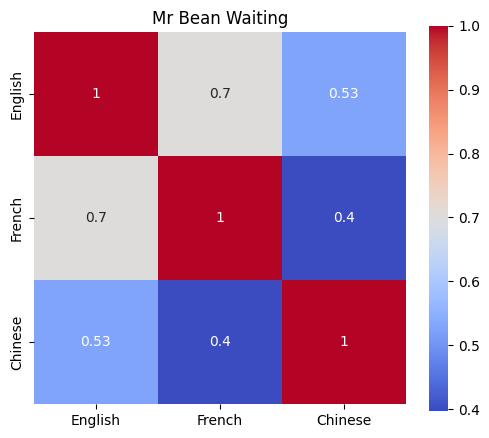

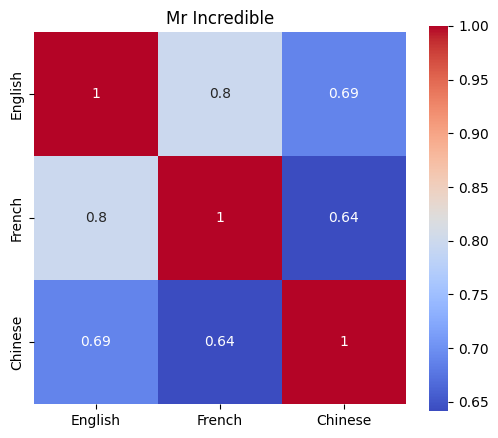

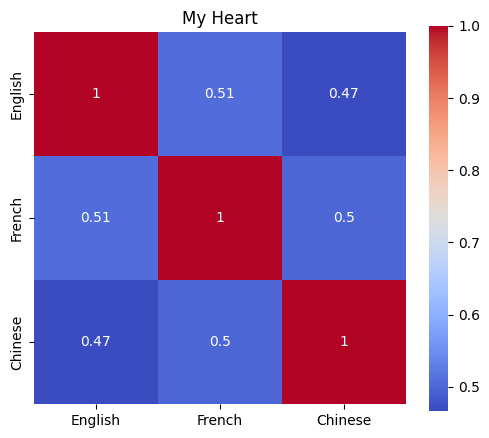

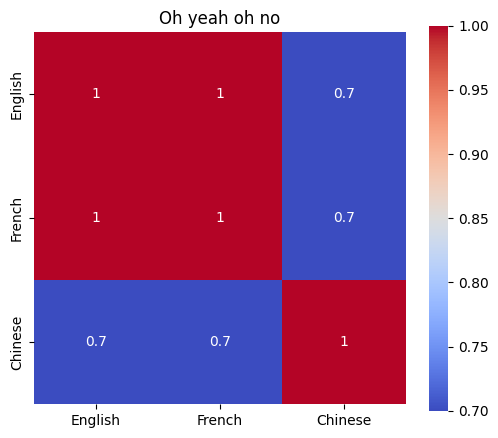

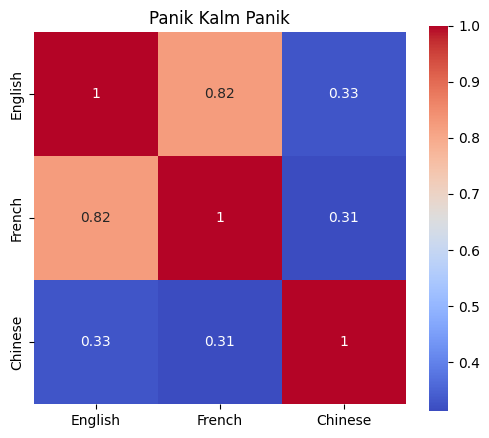

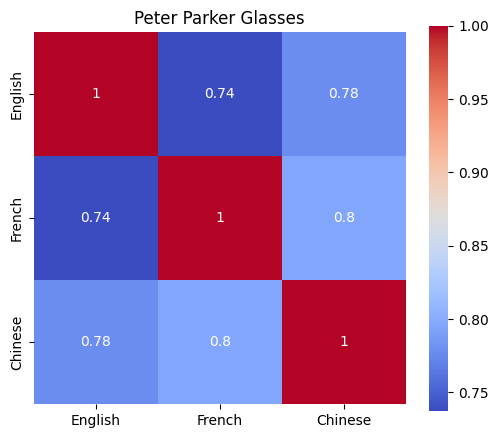

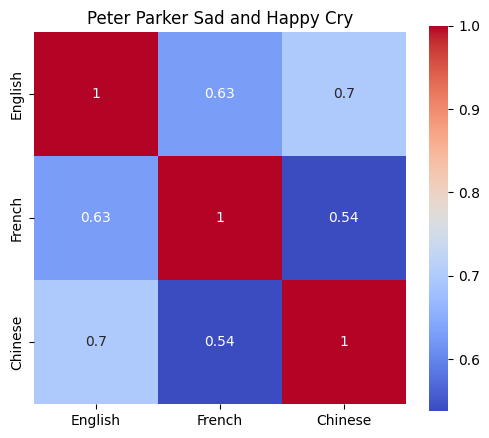

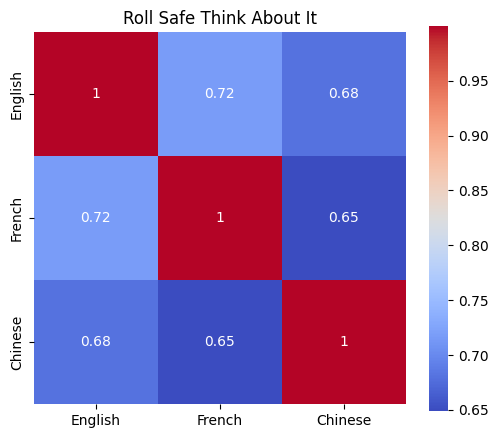

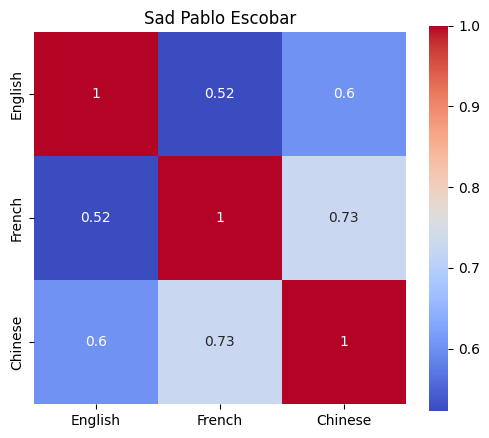

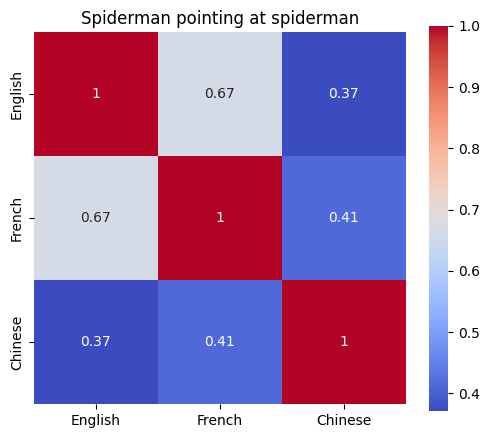

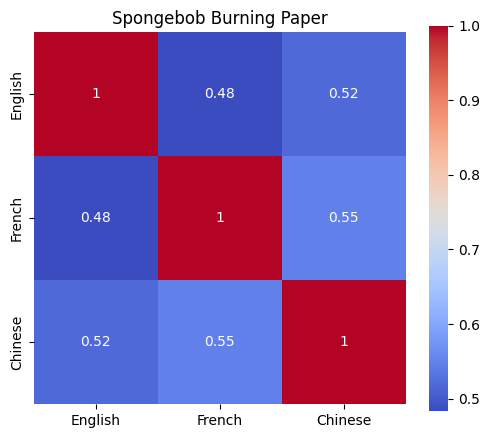

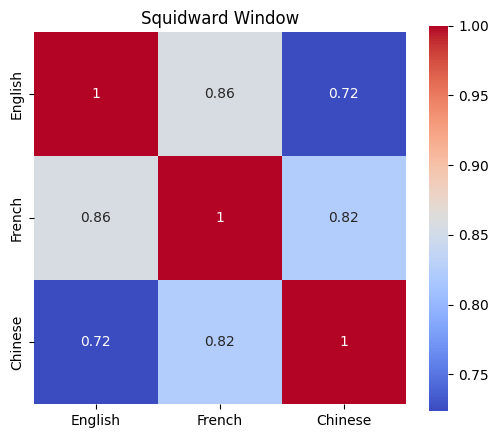

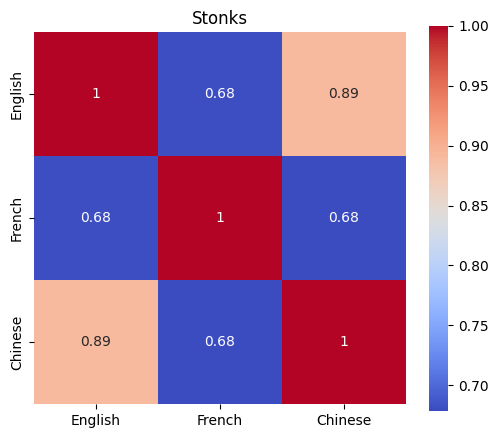

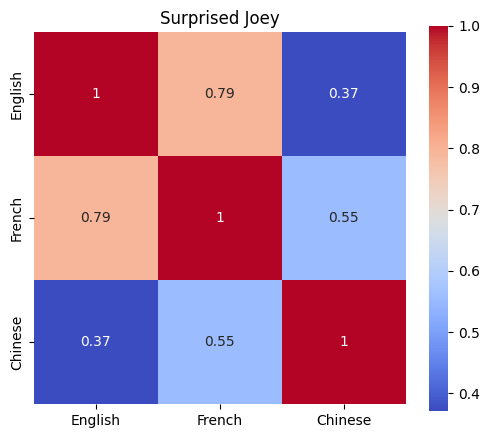

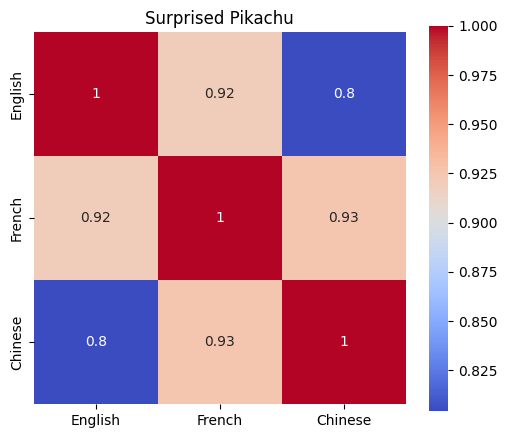

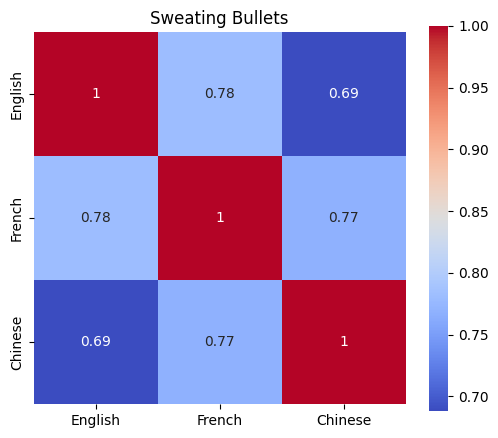

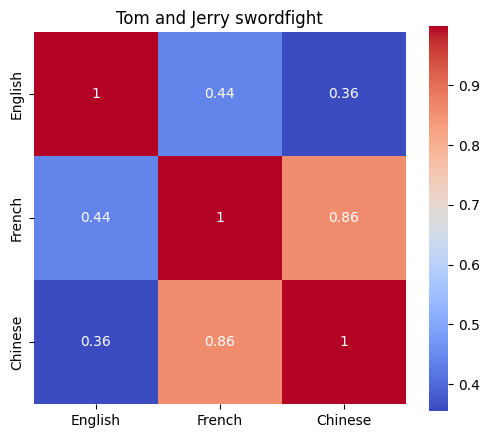

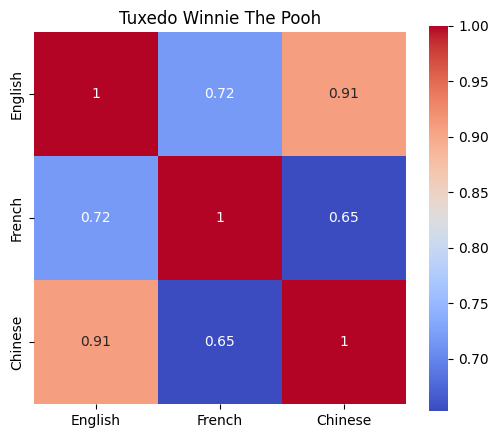

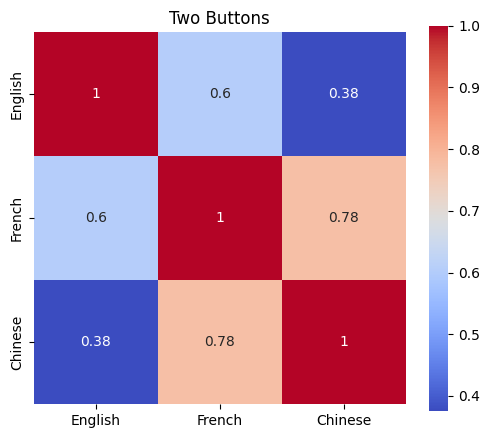

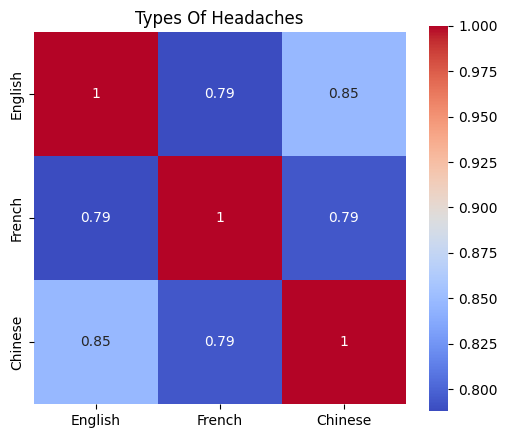

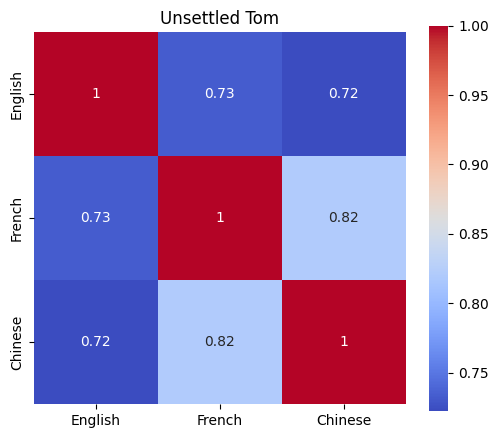

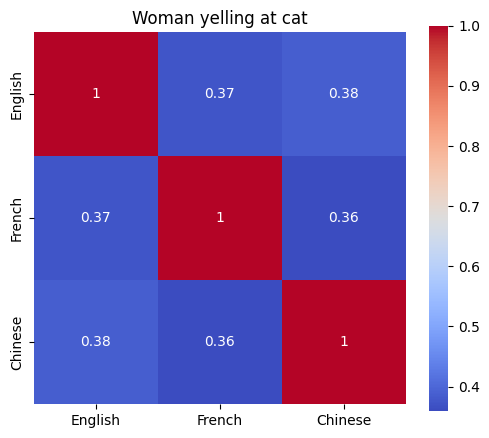

American Chopper Argument
	English - French: 0.6600
American Chopper Argument
	English - Chinese: 0.7870
American Chopper Argument
	French - Chinese: 0.8511
Anakin Padme 4 Panel
	English - French: 0.4523
Anakin Padme 4 Panel
	English - Chinese: 0.4530
Anakin Padme 4 Panel
	French - Chinese: 0.6135
Batman Slapping Robin
	English - French: 0.8305
Batman Slapping Robin
	English - Chinese: 0.6552
Batman Slapping Robin
	French - Chinese: 0.7994
Boardroom Meeting Suggestion
	English - French: 0.6420
Boardroom Meeting Suggestion
	English - Chinese: 0.4796
Boardroom Meeting Suggestion
	French - Chinese: 0.6401
Brain Before Sleep
	English - French: 0.5907
Brain Before Sleep
	English - Chinese: 0.7415
Brain Before Sleep
	French - Chinese: 0.6276
Buff Doge vs. Cheems
	English - French: 0.8119
Buff Doge vs. Cheems
	English - Chinese: 0.7456
Buff Doge vs. Cheems
	French - Chinese: 0.7638
Calculating Meme
	English - French: 0.4297
Calculating Meme
	English - Chinese: 0.5896
Calculating Meme
	French 

In [ ]:
sentence_embedder = SentenceTransformer('all-mpnet-base-v2')

# Group data by "Meme name"
grouped = df.groupby("Meme name")

# Store results
res = []

for meme_name, group in grouped:
    # Generate embeddings for the "Meme" texts
    embeddings = sentence_embedder.encode(group["Thought"].tolist())
    languages = group['Language'].tolist()

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)

    plt.figure(figsize=(6, 5))
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', cbar=True, square=True,
            xticklabels=[f"{language}" for language in languages],
            yticklabels=[f"{language}" for language in languages])
    plt.title(f"{meme_name}")
    plt.show()

    # Store the results
    languages = group["Language"].tolist()
    for i in range(len(languages)):
        for j in range(i + 1, len(languages)):
            res.append({
                "Meme name": meme_name,
                "Language Pair": f"{languages[i]} - {languages[j]}",
                "Cosine Similarity": similarity_matrix[i][j]
            })

# Convert results to DataFrame
similarity_df = pd.DataFrame(res)

# Print the results in the desired format with the language pair on a new line
for _, row in similarity_df.iterrows():
    print(f'{row["Meme name"]}\n\t{row["Language Pair"]}: {row["Cosine Similarity"]:.4f}')

In [ ]:
# Compute the average cosine similarity for each language pair
average_similarity_per_pair = similarity_df.groupby("Language Pair")["Cosine Similarity"].mean()

# Print the results
for language_pair, avg_similarity in average_similarity_per_pair.items():
    print(f'Average cosine similarity for {language_pair}: {avg_similarity:.4f}')

Average cosine similarity for English - Chinese: 0.6344
Average cosine similarity for English - French: 0.6815
Average cosine similarity for French - Chinese: 0.6519


<ipython-input-119-aee388f254d3>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],


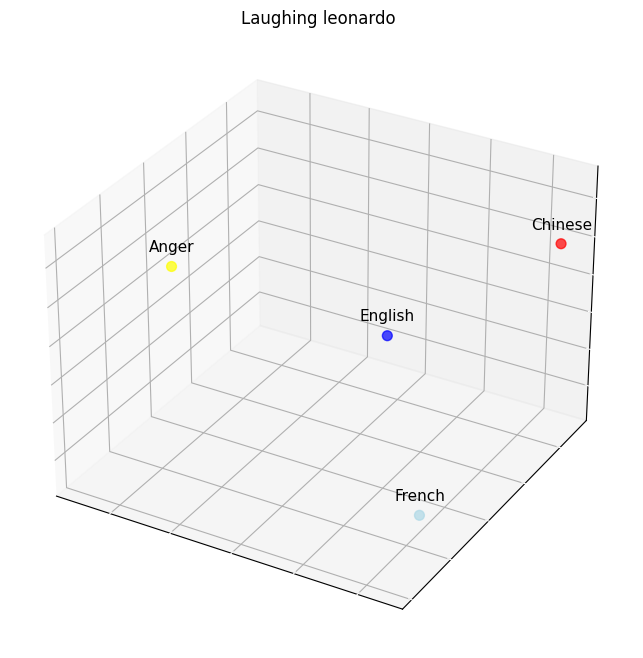

<ipython-input-119-aee388f254d3>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],


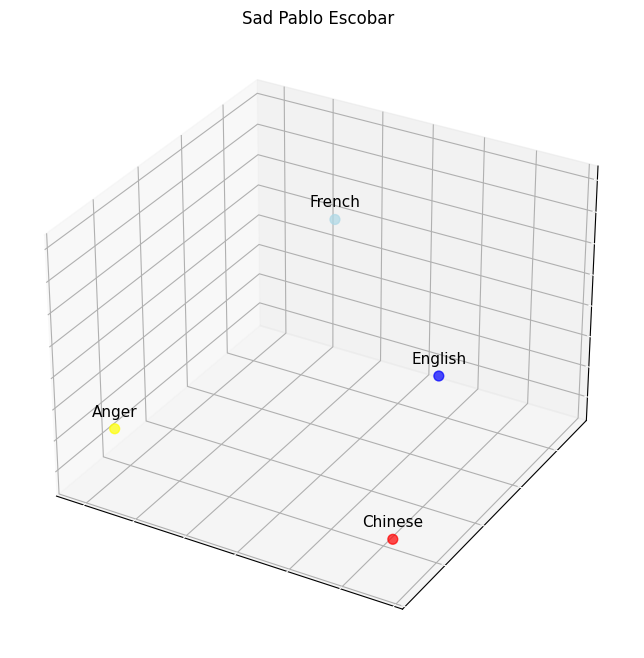

<ipython-input-119-aee388f254d3>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],


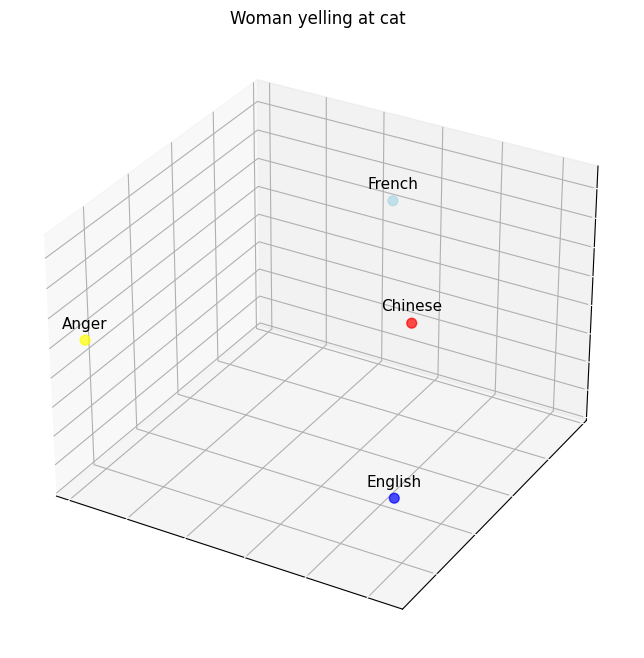

<ipython-input-119-aee388f254d3>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],


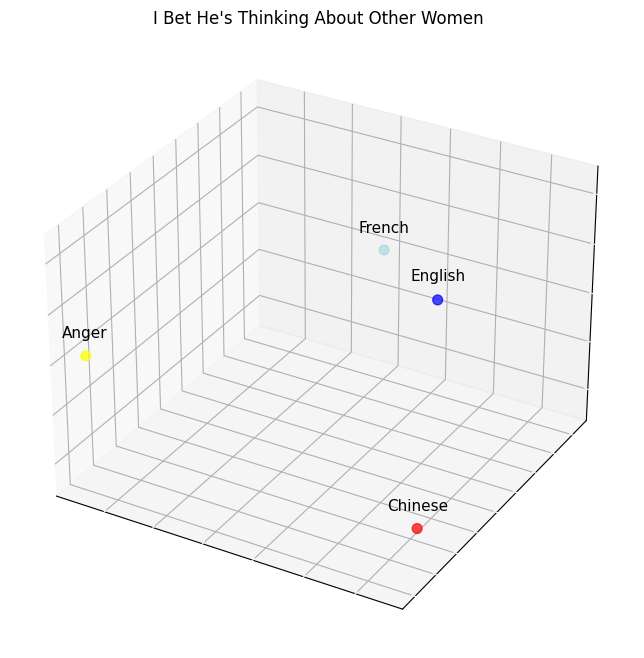

<ipython-input-119-aee388f254d3>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],


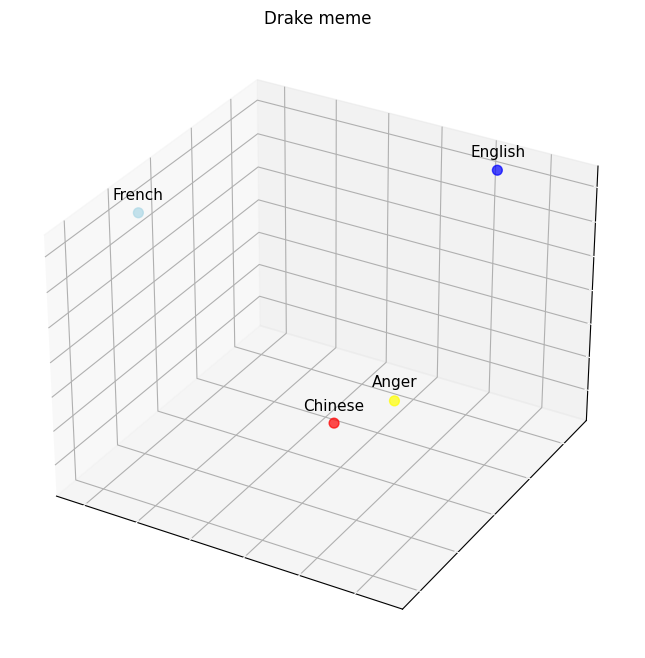

<ipython-input-119-aee388f254d3>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],


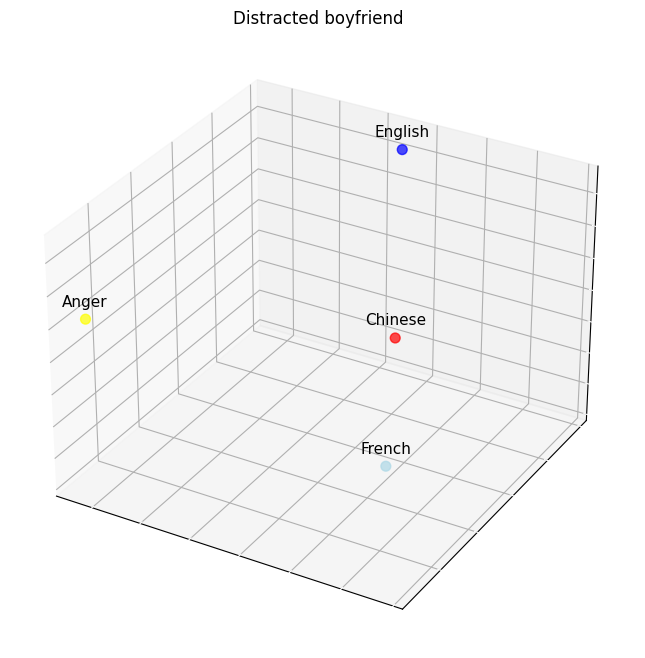

<ipython-input-119-aee388f254d3>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],


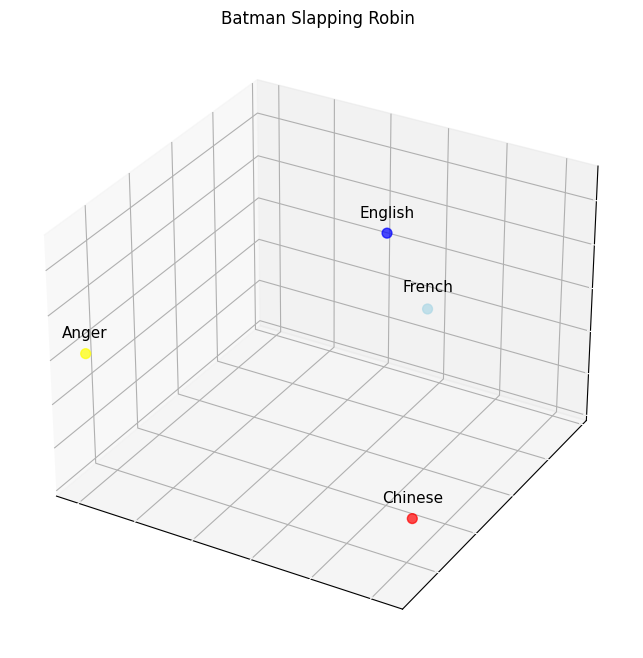

<ipython-input-119-aee388f254d3>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],


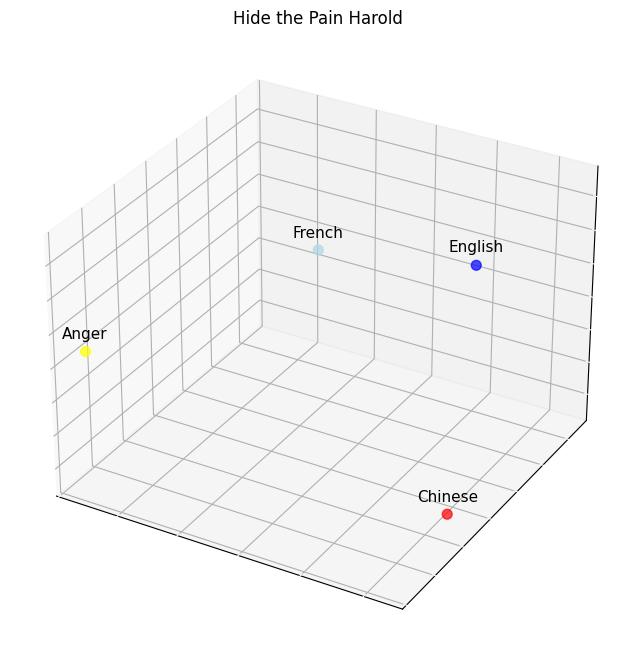

<ipython-input-119-aee388f254d3>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],


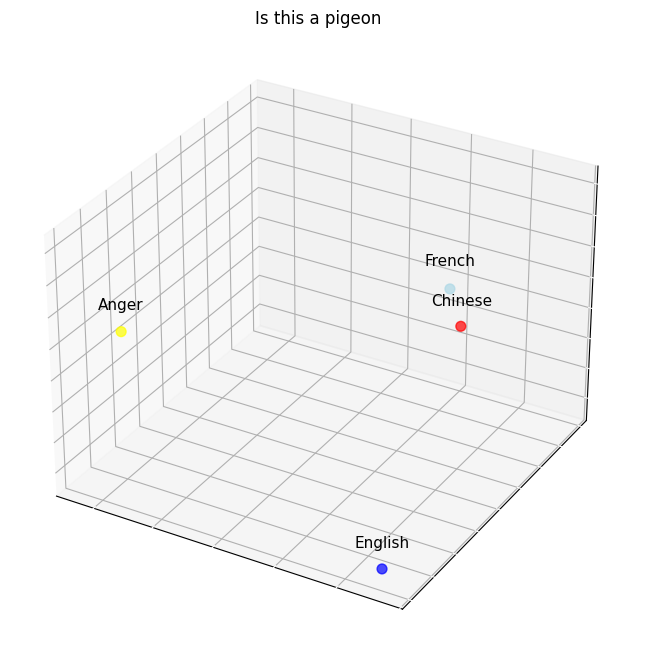

<ipython-input-119-aee388f254d3>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],


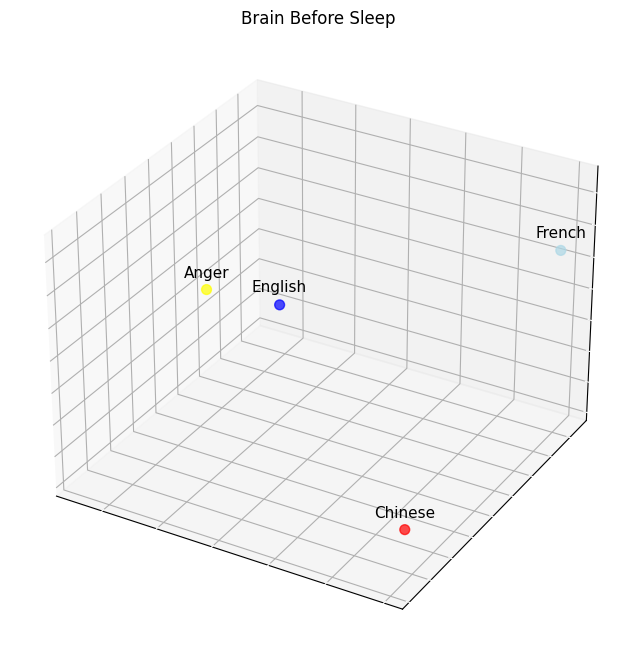

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_embeddings_3d(mn, embeddings, labels):
    # Perform PCA to reduce the dimensionality to 3D
    pca = PCA(n_components=3)
    embeddings_3d = pca.fit_transform(embeddings)

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Generate a list of unique labels and assign colors
    unique_labels = list(set(labels))


    # Get color for each point based on its label
    point_colors = ['blue', 'lightblue', 'red', 'yellow']

    # Scatter plot with color coding based on labels
    scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],
                         c=point_colors, cmap='viridis', s=50, alpha=0.7)

    # Adding labels and title
    ax.set_title(f'{mn}', color="black")

    plt.tick_params(colors='white')

    for i, label in enumerate(labels):
        ax.text(
            embeddings_3d[i, 0],
            embeddings_3d[i, 1],
            embeddings_3d[i, 2] + 0.03,  # Offset to appear above points
            label,
            fontsize=11,
            ha='center',
            va='bottom',
            color="black"  # Ensure text is white for contrast
        )


    # Show the plot
    plt.show()

USER_INPUT = "Anger"
input_embedding = sentence_embedder.encode(USER_INPUT)

for mn in df['Meme name'].unique():
    embeddings = [emb['Embedding'] for emb in embeddings_dataset if emb['Meme name'] == mn]
    embeddings.append(input_embedding)
    labels = [f"{emb['Language']}" for emb in embeddings_dataset if emb['Meme name'] == mn]
    labels.append(USER_INPUT)

    # Ensure the embeddings and labels are correctly matched
    assert len(embeddings) == len(labels)

    # Now plot using PCA for 3D visualization with labels
    plot_embeddings_3d(mn, embeddings, labels)  # 3D plot using PCA

<ipython-input-87-b2e0e82fa57f>:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Emotions", loc="upper right")


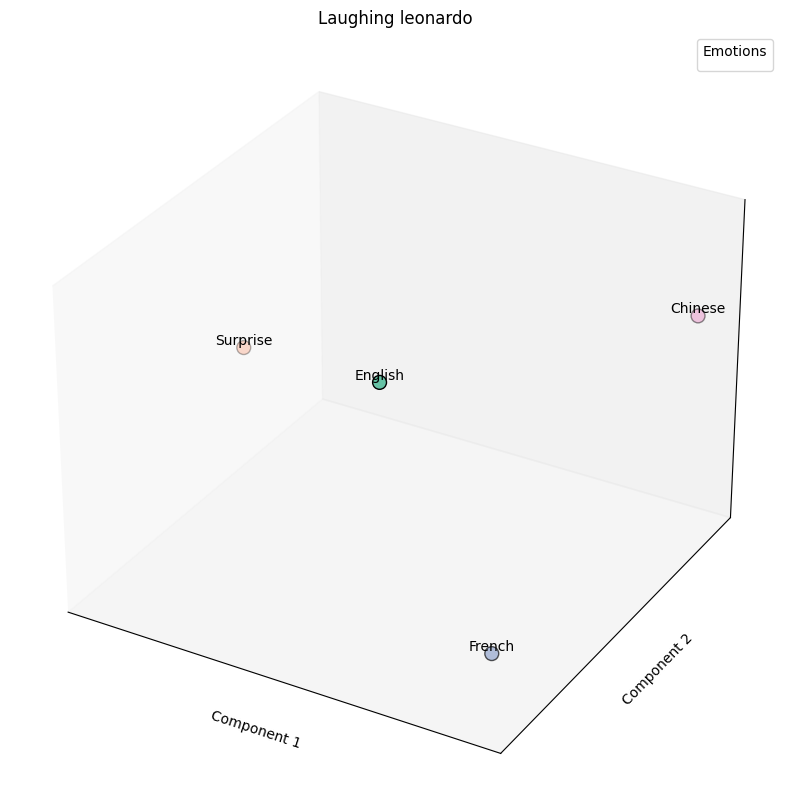

<ipython-input-87-b2e0e82fa57f>:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Emotions", loc="upper right")


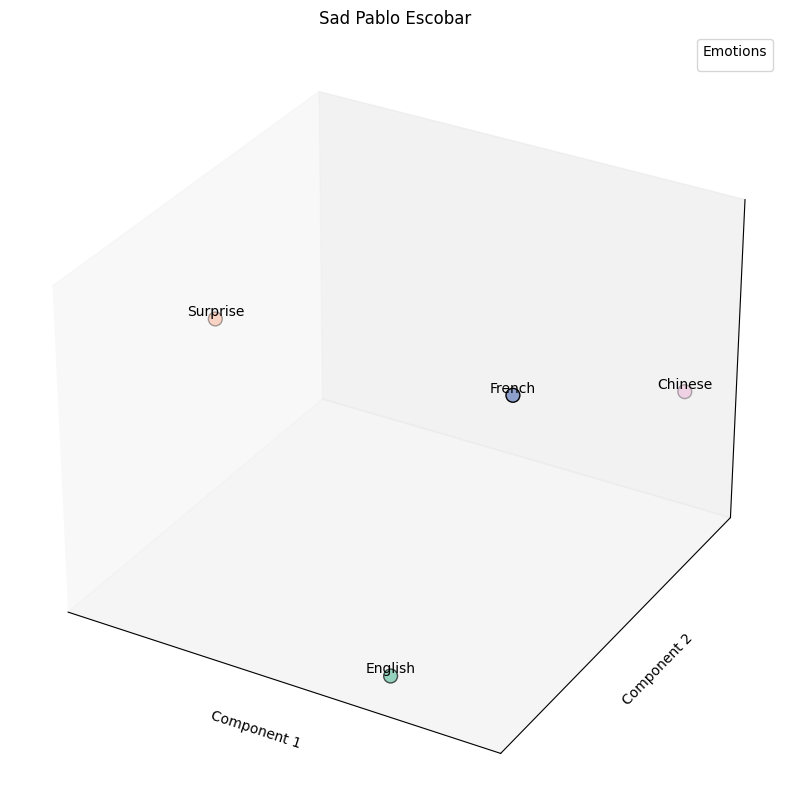

<ipython-input-87-b2e0e82fa57f>:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Emotions", loc="upper right")


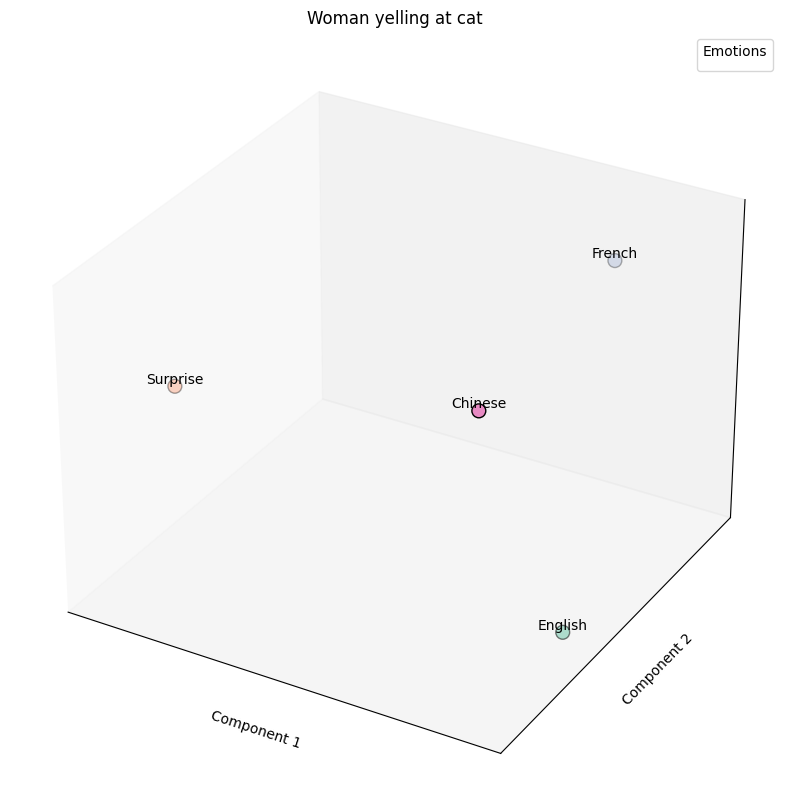

<ipython-input-87-b2e0e82fa57f>:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Emotions", loc="upper right")


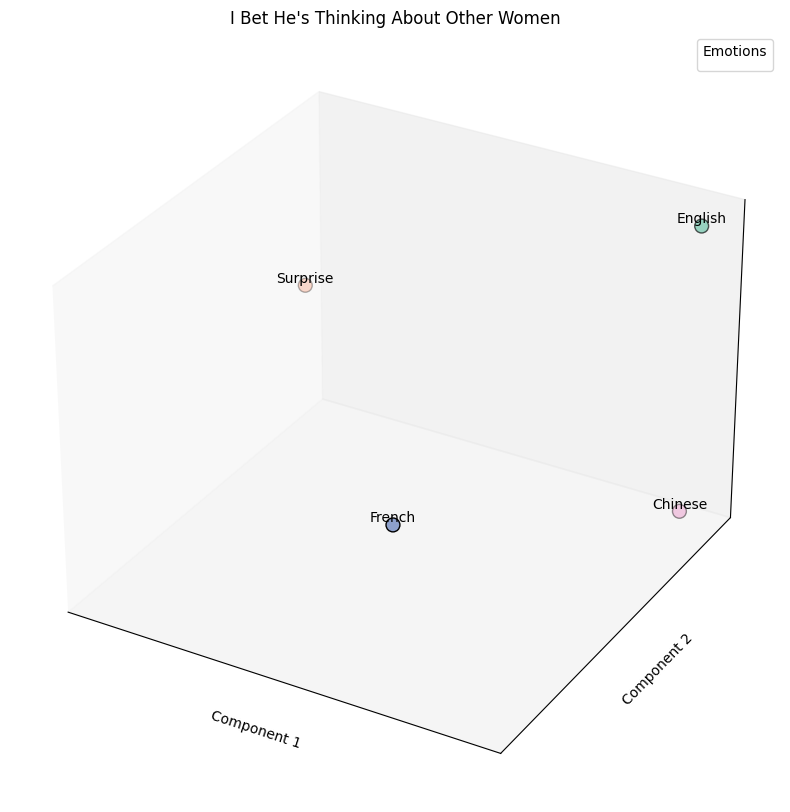

<ipython-input-87-b2e0e82fa57f>:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Emotions", loc="upper right")


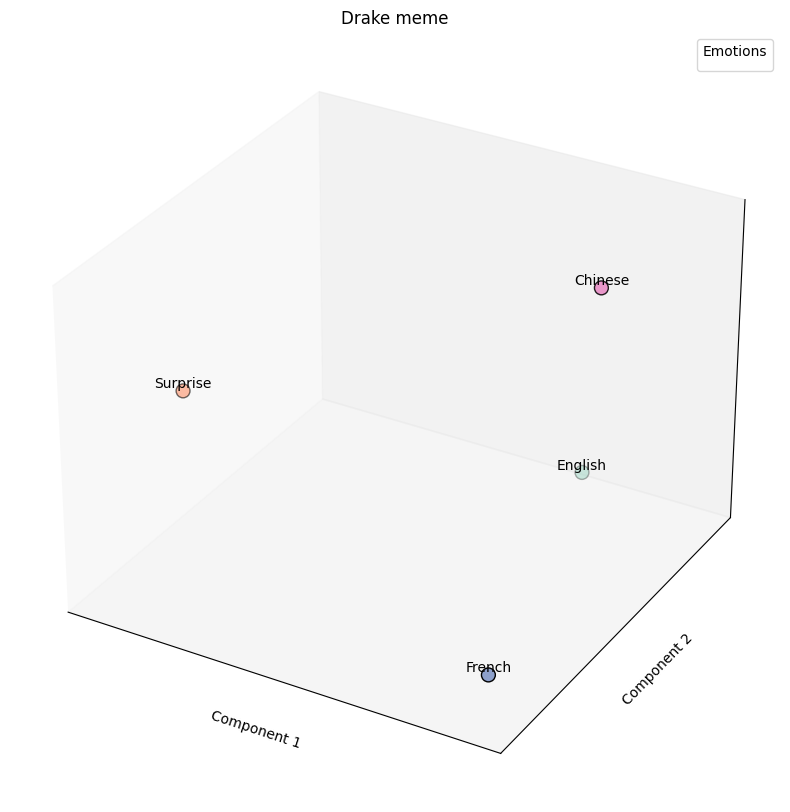

<ipython-input-87-b2e0e82fa57f>:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Emotions", loc="upper right")


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def plot_embeddings(mname, embeddings, labels, method='PCA', n_components=2):
    """
    Visualize embeddings using PCA or t-SNE with labels displayed on the graph.

    Parameters:
    - mname: Name of the meme being visualized.
    - embeddings: A 2D numpy array or list of embeddings.
    - labels: A list of labels associated with each embedding.
    - method: Method for dimensionality reduction, either 'PCA' or 't-SNE'.
    - n_components: Number of components for dimensionality reduction (2 or 3).
    """
    if method == 'PCA':
        reducer = PCA(n_components=n_components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=n_components)
    else:
        raise ValueError("Method must be 'PCA' or 't-SNE'.")

    # Reduce the dimensionality of embeddings
    reduced_embeddings = reducer.fit_transform(embeddings)

    # Create the plot
    plt.figure(figsize=(12, 10))

    if n_components == 2:
        sns.scatterplot(
            x=reduced_embeddings[:, 0],
            y=reduced_embeddings[:, 1],
            hue=labels,
            palette="Set2",
            s=100,
            marker='o',
            edgecolor='black'
        )
        plt.xticks([])  # Remove x-axis tick labels
        plt.yticks([])  # Remove y-axis tick labels
    else:
        # For 3D plot
        ax = plt.axes(projection='3d')
        # Generate a list of unique labels and assign colors
        unique_labels = list(set(labels))
        colors = sns.color_palette("Set2", n_colors=len(unique_labels))
        # Create a dictionary mapping labels to colors
        label_color_map = dict(zip(unique_labels, colors))

        # Get color for each point based on its label
        point_colors = [label_color_map[label] for label in labels]

        # Plot the 3D scatter plot
        scatter = ax.scatter3D(
            reduced_embeddings[:, 0],
            reduced_embeddings[:, 1],
            reduced_embeddings[:, 2],
            c=point_colors,
            s=100,
            marker='o',
            edgecolor='black'
        )

        # Add labels on top of each point
        for i in range(len(reduced_embeddings)):
            ax.text(
                reduced_embeddings[i, 0],
                reduced_embeddings[i, 1],
                reduced_embeddings[i, 2],
                labels[i],
                color='black',
                fontsize=10,
                verticalalignment='bottom',  # Position the label above the point
                horizontalalignment='center'
            )

        # Add grid to the 3D plot
        ax.grid(True)

        # Remove ticks for clarity
        ax.set_xticks([])  # Remove x-axis tick labels
        ax.set_yticks([])  # Remove y-axis tick labels
        ax.set_zticks([])  # Remove z-axis tick labels

    plt.title(f'{mname}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.legend(title="Emotions", loc="upper right")
    plt.show()

# Example usage:
# Assuming embeddings is a list of emotion vectors and labels contains corresponding labels (like "happy", "sad", etc.).
# Here is a dummy example for testing purposes:

USER_INPUT = "Surprise"
input_embedding = sentence_embedder.encode(USER_INPUT)

for mn in df['Meme name'].unique():
    embeddings = [emb['Embedding'] for emb in embeddings_dataset if emb['Meme name'] == mn]
    embeddings.append(input_embedding)
    labels = [f"{emb['Language']}" for emb in embeddings_dataset if emb['Meme name'] == mn]
    labels.append(USER_INPUT)

    # Ensure the embeddings and labels are correctly matched
    assert len(embeddings) == len(labels)

    # Now plot using PCA for 3D visualization with labels
    plot_embeddings(mn, embeddings, labels, method='PCA', n_components=3)  # 3D plot using PCA
